In [1]:
import os
import pickle
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from model import *
from trainer import *

## Initialize data

In [2]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [3]:
model_test_name = '1_encoder_1_decoder_with_skips_localign'

# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 4
lr = 0.02
warmup_steps = 10
decay_factor = 0.5
smoothing = 0.05

epochs = 150
early_stopping = 5
log_interval = 150  # Print log every `log_interval` batches

In [4]:
# Model hyperparameters
embed_size = 512
encode_size = 256
h_size = 256
loc_align_size = 256
loc_align_kernel = 5
decode_size = 256
decode_out_size = 512
n_enc_layers = 1
attn_rnn_layers = 1
n_dec_layers = 1
smooth_align = True
align_location = True
skip_connections = True

The learning rate scheduler sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

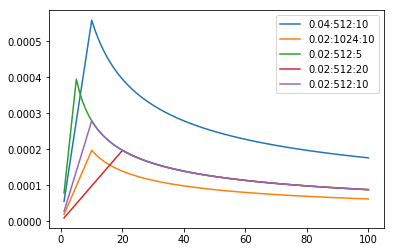

In [5]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps*2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.4g:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps*2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps),
])

## Initialize model, criterion, optimizer, and learning rate scheduler

In [6]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    encode_size = encode_size, h_size = h_size, decode_size = decode_size,
    decode_out_size = decode_out_size, n_enc_layers = n_enc_layers,
    attn_rnn_layers = attn_rnn_layers, n_dec_layers = n_dec_layers,
    align_location = align_location, loc_align_size = loc_align_size,
    loc_align_kernel = loc_align_kernel, smooth_align = smooth_align,
    skip_connections = skip_connections, dropout = dropout
)
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
eval_criterion = LabelSmoothing(ntokens, smoothing = 0)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, decay_factor, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 8746001


## Train
Ready the data

In [11]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([12562, 74]), torch.Size([7376, 10]), torch.Size([8243, 10]))

Train and evaluate

In [14]:
train_stats, stat, train_loss, data, targets, states, nstates = train_eval_loop(
    model, train_data, val_data, batch_size, eval_batch_size,
    seq_len, ntokens, criterion, eval_criterion, optimizer,
    lr_scheduler, epochs, warmup_steps, early_stopping,
    clip, log_interval
)

Epoch   1/ 50) lr = 2.795e-05 (warmup)
 b 150/718 >> 2537.5 ms/b | lr:  2.6e-05 | grad norm: 1.89 | max abs grad:   0.110 | loss: 7.22 | perp.: 1370.37
 b 300/718 >> 2524.7 ms/b | lr:    3e-05 | grad norm: 1.43 | max abs grad:   0.058 | loss: 6.19 | perp.: 488.05
 b 450/718 >> 2505.9 ms/b | lr:  2.9e-05 | grad norm: 1.31 | max abs grad:   0.056 | loss: 6.16 | perp.: 473.74
 b 600/718 >> 2401.8 ms/b | lr:  2.6e-05 | grad norm: 1.22 | max abs grad:   0.039 | loss: 6.12 | perp.: 457.13
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1785.04 sec | train_loss:  6.36 | train_perp: 579.44 | valid_loss:  6.03 | valid_perp.: 417.58


Epoch   2/ 50) lr = 5.59e-05 (warmup)
 b 150/719 >> 2447.7 ms/b | lr:  4.8e-05 | grad norm: 1.41 | max abs grad:   0.052 | loss: 6.10 | perp.: 447.35
 b 300/719 >> 2508.7 ms/b | lr:  5.4e-05 | grad norm: 0.97 | max abs grad:   0.027 | loss: 6.03 | perp.: 415.77
 b 450/719 >> 2421.9 ms/b 

 b 150/714 >> 2525.4 ms/b | lr:  0.00027 | grad norm: 3.07 | max abs grad:   0.107 | loss: 4.14 | perp.:  62.49
 b 300/714 >> 2479.6 ms/b | lr:  0.00027 | grad norm: 3.75 | max abs grad:   0.163 | loss: 4.05 | perp.:  57.46
 b 450/714 >> 2466.1 ms/b | lr:  0.00027 | grad norm: 7.37 | max abs grad:   0.415 | loss: 4.00 | perp.:  54.85
 b 600/714 >> 2490.0 ms/b | lr:  0.00024 | grad norm: 3.39 | max abs grad:   0.134 | loss: 4.04 | perp.:  56.66
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1781.40 sec | train_loss:  4.08 | train_perp:  59.03 | valid_loss:  3.89 | valid_perp.:  48.73


Epoch  12/ 50) lr = 0.0002552
 b 150/721 >> 2517.6 ms/b | lr:  0.00024 | grad norm: 3.56 | max abs grad:   0.233 | loss: 3.92 | perp.:  50.47
 b 300/721 >> 2450.4 ms/b | lr:  0.00024 | grad norm: 3.11 | max abs grad:   0.194 | loss: 3.81 | perp.:  45.26
 b 450/721 >> 2469.3 ms/b | lr:  0.00026 | grad norm: 3.86 | max abs grad:

 b 300/718 >> 2510.1 ms/b | lr:  0.00018 | grad norm: 4.78 | max abs grad:   0.361 | loss: 3.20 | perp.:  24.52
 b 450/718 >> 2416.3 ms/b | lr:  0.00016 | grad norm: 3.49 | max abs grad:   0.257 | loss: 3.10 | perp.:  22.29
 b 600/718 >> 2445.1 ms/b | lr:  0.00022 | grad norm: 13.65 | max abs grad:   0.774 | loss: 3.08 | perp.:  21.85
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1774.57 sec | train_loss:  3.15 | train_perp:  23.40 | valid_loss:  3.04 | valid_perp.:  20.81


Epoch  22/ 50) lr = 0.0001884
 b 150/716 >> 2526.2 ms/b | lr:  0.00018 | grad norm: 4.83 | max abs grad:   0.466 | loss: 3.11 | perp.:  22.40
 b 300/716 >> 2460.2 ms/b | lr:  0.00019 | grad norm: 18.33 | max abs grad:   0.864 | loss: 3.05 | perp.:  21.16
 b 450/716 >> 2453.9 ms/b | lr:  0.00017 | grad norm: 5.82 | max abs grad:   0.555 | loss: 3.10 | perp.:  22.11
 b 600/716 >> 2501.5 ms/b | lr:   0.0002 | grad norm: 27.90 | max abs gr

 b 450/729 >> 2415.6 ms/b | lr:  0.00016 | grad norm: 6.40 | max abs grad:   0.237 | loss: 2.78 | perp.:  16.14
 b 600/729 >> 2405.5 ms/b | lr:  0.00014 | grad norm: 4.06 | max abs grad:   0.203 | loss: 2.75 | perp.:  15.60
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1776.80 sec | train_loss:  2.84 | train_perp:  17.19 | valid_loss:  2.71 | valid_perp.:  15.00


Epoch  32/ 50) lr = 0.0001563
 b 150/722 >> 2503.1 ms/b | lr:  0.00016 | grad norm: 15.89 | max abs grad:   1.954 | loss: 2.81 | perp.:  16.68
 b 300/722 >> 2445.7 ms/b | lr:  0.00016 | grad norm: 44.49 | max abs grad:   1.419 | loss: 2.82 | perp.:  16.72
 b 450/722 >> 2459.4 ms/b | lr:  0.00014 | grad norm: 3.36 | max abs grad:   0.290 | loss: 2.78 | perp.:  16.10
 b 600/722 >> 2485.4 ms/b | lr:  0.00016 | grad norm: 87.98 | max abs grad:   4.855 | loss: 2.76 | perp.:  15.82
-----------------------------------------------------------------------

 b 600/721 >> 2483.4 ms/b | lr:  0.00015 | grad norm: 11.23 | max abs grad:   0.569 | loss: 2.57 | perp.:  13.01
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1776.67 sec | train_loss:  2.62 | train_perp:  13.78 | valid_loss:  2.44 | valid_perp.:  11.46


Epoch  42/ 50) lr = 0.0001364
 b 150/723 >> 2440.4 ms/b | lr:  0.00013 | grad norm: 7.51 | max abs grad:   0.595 | loss: 2.51 | perp.:  12.33
 b 300/723 >> 2410.0 ms/b | lr:  0.00013 | grad norm: 13.65 | max abs grad:   0.640 | loss: 2.43 | perp.:  11.38
 b 450/723 >> 2495.3 ms/b | lr:  0.00012 | grad norm: 5.53 | max abs grad:   0.459 | loss: 2.57 | perp.:  13.03
 b 600/723 >> 2507.9 ms/b | lr:  0.00012 | grad norm: 4.30 | max abs grad:   0.167 | loss: 2.54 | perp.:  12.67
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1777.54 sec | train_loss:  2.55 | train_perp:  12.78 | va

In [15]:
CAUSES = ['output', 'grad']
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    _states = states
    if model.n_enc_layers > 0:
        enc_states = states[0]
        states = states[1:]
    if model.n_dec_layers > 0:
        dec_states = states[-1]
        states = states[:-1]
    attn_states = states[0]
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])
else:
    # Save training stats
    with open(os.path.join('stats', model_test_name+'.pkl'), 'wb') as f:
        pickle.dump(train_stats, f)
    with open(os.path.join('models', model_test_name+'.pt'), 'wb') as f:
        torch.save(model.state_dict(), f)

In [16]:
test_loss = evaluate(test_data, save_wts = True)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

test_loss:  2.24 | test_perplexity:  9.40


## Evaluate predictions

In [17]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [18]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [19]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

6 incorrectly predicted
 Variable containing:

Columns 0 to 12 
  229  1655   812  4676    42   935  3257   674    24   804  2373    42   252
   42  2373   812    42    42   935  3257   674    24  2373  2373    42   252

Columns 13 to 17 
  230  1038   119  4561  1890
  230  1038   119   935  2373
[torch.LongTensor of size 2x18]

7 incorrectly predicted
 Variable containing:

Columns 0 to 12 
   64  1573   109  4931    64   133    27    27   169    27    27   549    24
   27    27   109    27    64    27    27    27   169    27    27    24    24

Columns 13 to 17 
 1041    32  5941  1256  1257
   32    32  5941  1256    27
[torch.LongTensor of size 2x18]

6 incorrectly predicted
 Variable containing:

Columns 0 to 12 
  204  1452  1725    42    32  1847   119  5463   798  1656    35  3509  2680
  119   119  1725    42    32   119   119  5463   596    35    35  3509    26

Columns 13 to 17 
   26  5463   119    26    26
   26  5463   119    26    26
[torch.LongTensor of size 2x18]

4 in

## Visualizations

Some basic weight heat maps to start:

(10000, 512)

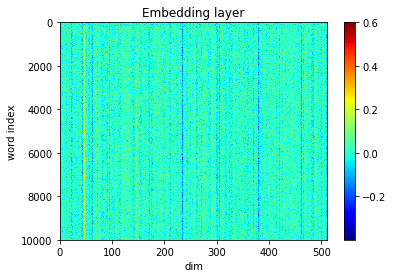

In [21]:
embed_wts = np.array(model.embedding.weight.data)
embed_norm = (embed_wts - embed_wts.mean()) / (embed_wts.max() - embed_wts.min())
plt.imshow(embed_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [22]:
attn = model.attn

(256, 768)

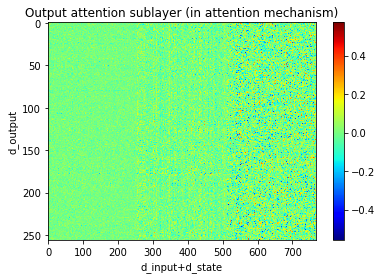

In [23]:
attn_wts = np.array(attn.attention.weight.data)
attn_norm = (attn_wts - attn_wts.mean()) / (attn_wts.max() - attn_wts.min())
plt.imshow(attn_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state'); plt.ylabel('d_output')
plt.title('Output attention sublayer (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

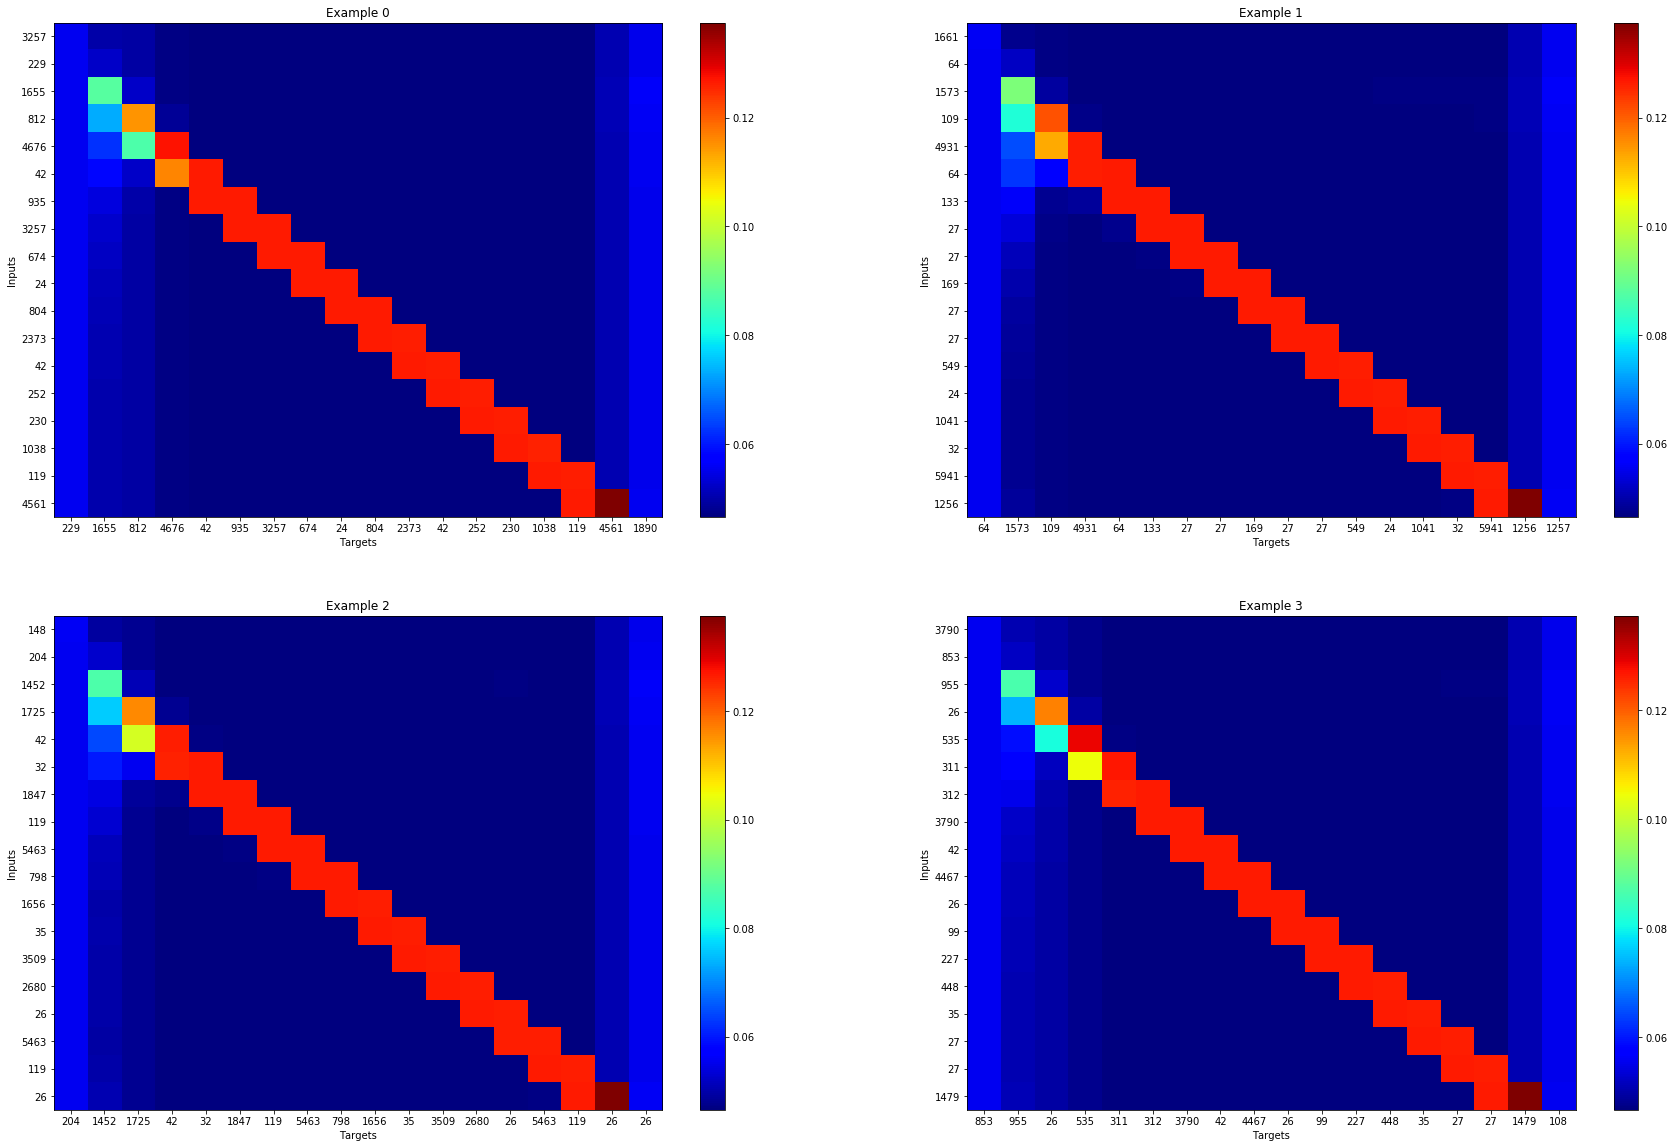

In [24]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()